In [146]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
#path = Path('data/food-101/images')
path = Path('../data/subset')


In [4]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=64).normalize(imagenet_stats)

In [5]:
data.classes


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 10,
 8035,
 1965)

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)


In [8]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate, model_dir="../../prod")
#learn.model = torch.nn.DataParallel(learn.model)


In [9]:
learn.fit_one_cycle(4)


Total time: 03:03
epoch  train_loss  valid_loss  error_rate
1      0.897566    0.645430    0.216285    (00:47)
2      0.595806    0.492758    0.157252    (00:44)
3      0.434488    0.452815    0.150127    (00:45)
4      0.336350    0.433548    0.141985    (00:45)



In [10]:
model_name="resnet50"

In [11]:
learn.save(f'{model_name}-stage-1')

In [12]:
learn.load(f'{model_name}-stage-1')

In [13]:
learn.unfreeze()


In [14]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


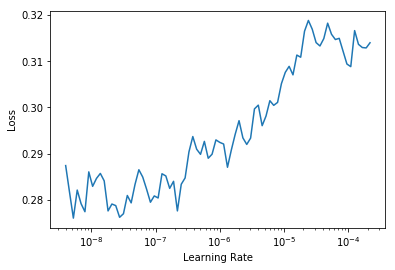

In [15]:
learn.recorder.plot(skip_end=10)


In [16]:
learn.fit_one_cycle(5, max_lr=slice(1e-7,1e-4))


Total time: 04:06
epoch  train_loss  valid_loss  error_rate
1      0.301539    0.429736    0.137405    (00:49)
2      0.304044    0.420826    0.136387    (00:49)
3      0.278203    0.413375    0.136387    (00:49)
4      0.262110    0.413985    0.133333    (00:48)
5      0.265581    0.412471    0.133842    (00:49)



In [17]:
learn.save(f'{model_name}-stage-2')

# Interpretation

In [18]:
learn.load(f'{model_name}-stage-2')


In [19]:
interp = ClassificationInterpretation.from_learner(learn)


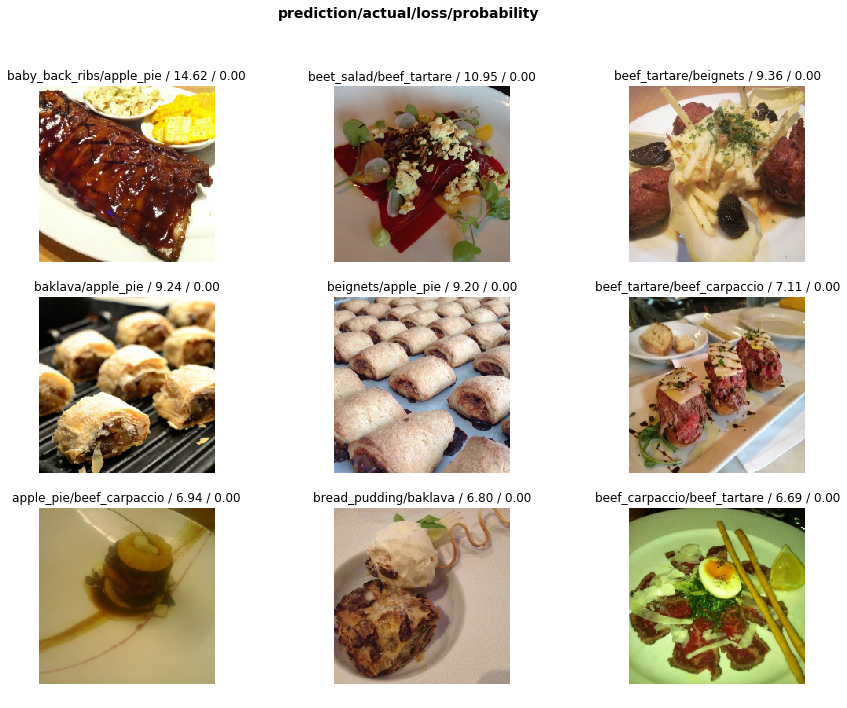

In [20]:
interp.plot_top_losses(9, figsize=(15,11))


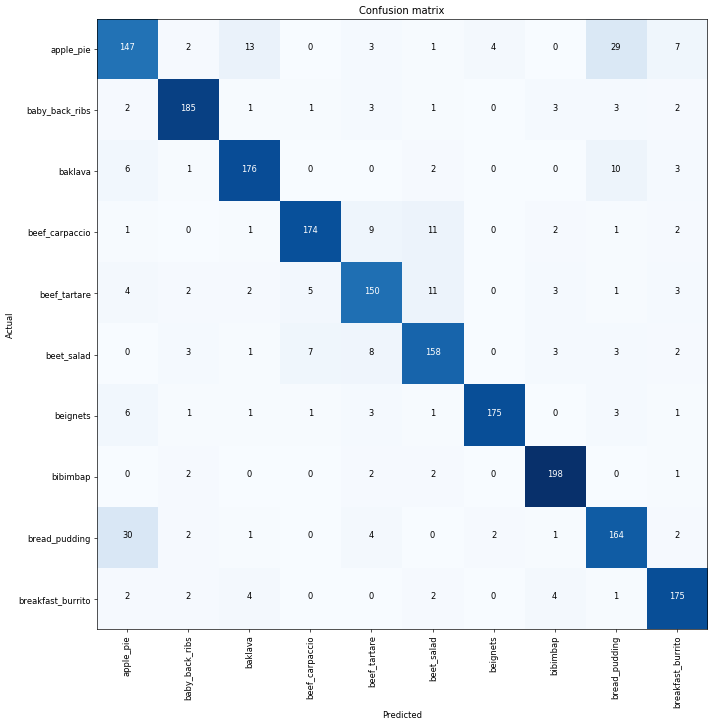

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [22]:
interp.most_confused(min_val=2)


[('bread_pudding', 'apple_pie', 30),
 ('apple_pie', 'bread_pudding', 29),
 ('apple_pie', 'baklava', 13),
 ('beef_carpaccio', 'beet_salad', 11),
 ('beef_tartare', 'beet_salad', 11),
 ('baklava', 'bread_pudding', 10),
 ('beef_carpaccio', 'beef_tartare', 9),
 ('beet_salad', 'beef_tartare', 8),
 ('apple_pie', 'breakfast_burrito', 7),
 ('beet_salad', 'beef_carpaccio', 7),
 ('baklava', 'apple_pie', 6),
 ('beignets', 'apple_pie', 6),
 ('beef_tartare', 'beef_carpaccio', 5),
 ('apple_pie', 'beignets', 4),
 ('beef_tartare', 'apple_pie', 4),
 ('bread_pudding', 'beef_tartare', 4),
 ('breakfast_burrito', 'baklava', 4),
 ('breakfast_burrito', 'bibimbap', 4),
 ('apple_pie', 'beef_tartare', 3),
 ('baby_back_ribs', 'beef_tartare', 3),
 ('baby_back_ribs', 'bibimbap', 3),
 ('baby_back_ribs', 'bread_pudding', 3),
 ('baklava', 'breakfast_burrito', 3),
 ('beef_tartare', 'bibimbap', 3),
 ('beef_tartare', 'breakfast_burrito', 3),
 ('beet_salad', 'baby_back_ribs', 3),
 ('beet_salad', 'bibimbap', 3),
 ('beet_sa

In [34]:
final_model_name = f'{model_name}-final'

In [35]:
learn.save(final_model_name)

# Testing on Different Data

### Loading Trained model

In [36]:
learn.load(final_model_name)

In [37]:
learn.data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [39]:
data2 = ImageDataBunch.single_from_classes(path, data.classes
                                           , tfms=get_transforms()
                                           , size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet50)
learn.load(final_model_name)

In [40]:
data2.classes, data2.c


(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 10)

**bibimbap**

In [43]:
bibimbap_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Dolsot-bibimbap.jpg/1200px-Dolsot-bibimbap.jpg"

In [ ]:
#!wget {url} -O sample.jpg

In [44]:
url = bibimbap_url

In [78]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

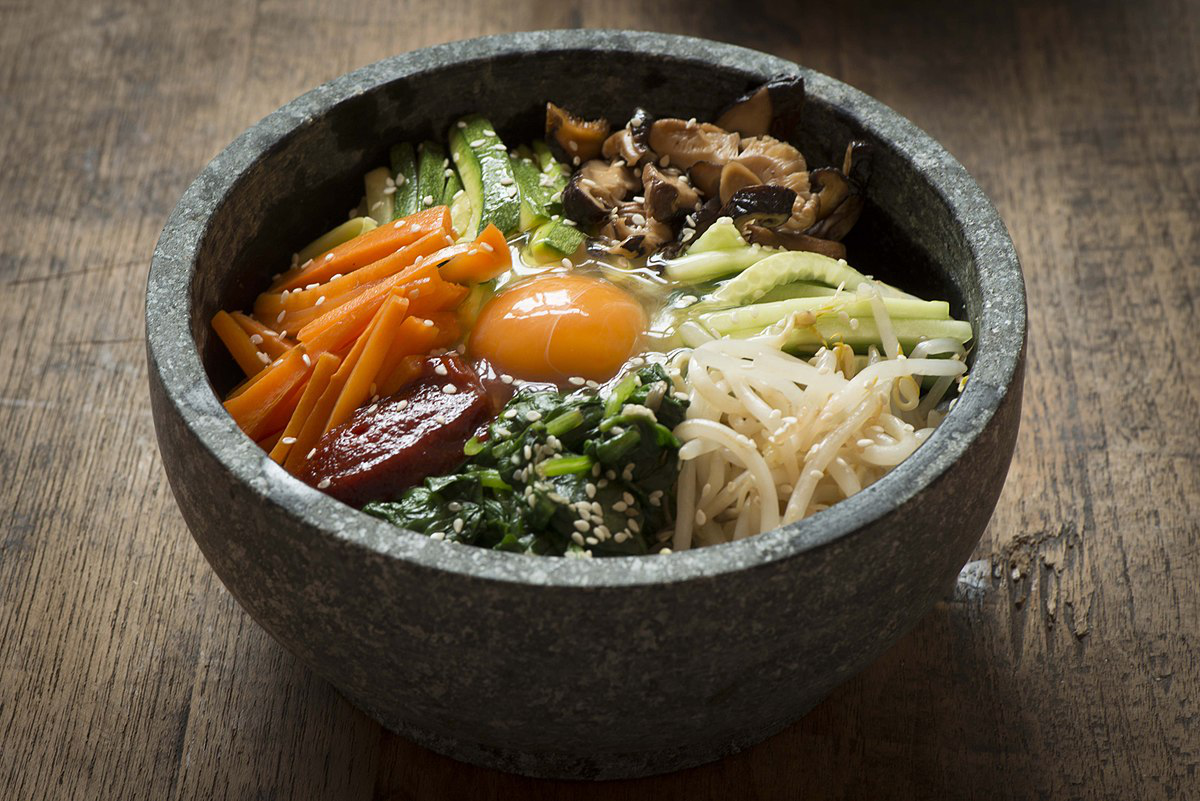

In [71]:
img = fetch_image(bibimbap_url)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class , pred_idx, outputs

('bibimbap',
 tensor(7),
 tensor([1.2469e-02, 3.1634e+00, 1.6414e-01, 1.4150e-01, 5.4390e-01, 3.2021e+01,
         9.4270e-01, 9.0188e+05, 4.8956e-02, 6.9307e-02]))

In [109]:
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    pprint.pprint( (sorted(res, key=lambda x:x[1], reverse=True)  ))
    return img.resize(500)

**Baby Back Rib**

In [110]:
baby_back_url ="https://upload.wikimedia.org/wikipedia/commons/e/ee/Baby_back_ribs_with_fries.jpg"

[('baby_back_ribs', 11881.310546875),
 ('beef_tartare', 14.305257797241211),
 ('bibimbap', 0.8018304109573364),
 ('bread_pudding', 0.8015013933181763),
 ('baklava', 0.40333130955696106),
 ('beet_salad', 0.3159133493900299),
 ('beef_carpaccio', 0.16588585078716278),
 ('beignets', 0.1265896111726761),
 ('breakfast_burrito', 0.07063547521829605),
 ('apple_pie', 0.06609132885932922)]


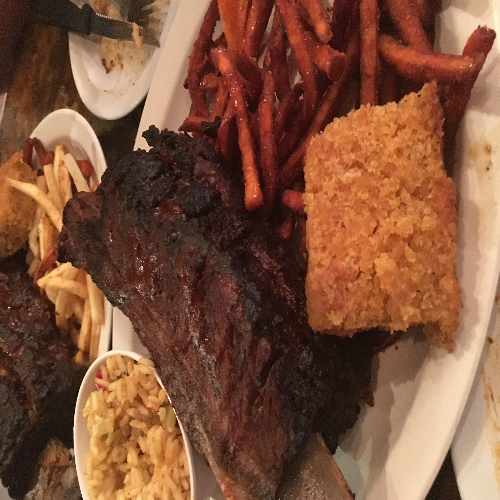

In [111]:
predict(baby_back_url)

**Cat**

In [112]:
cat_image_url = "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492__480.jpg"

[('beignets', 9.376317024230957),
 ('bibimbap', 7.215067386627197),
 ('apple_pie', 3.296311378479004),
 ('baklava', 1.6615041494369507),
 ('beef_tartare', 0.9499176144599915),
 ('beet_salad', 0.910473644733429),
 ('breakfast_burrito', 0.6568726897239685),
 ('bread_pudding', 0.28667783737182617),
 ('beef_carpaccio', 0.08717743307352066),
 ('baby_back_ribs', 0.0675472691655159)]


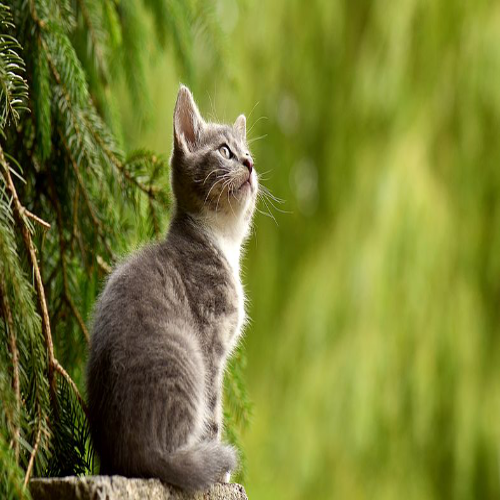

In [113]:
predict(cat_image_url)

In [114]:
icecream_url = "https://upload.wikimedia.org/wikipedia/commons/3/31/Ice_Cream_dessert_02.jpg"

[('apple_pie', 3239.3994140625),
 ('bread_pudding', 96.34784698486328),
 ('baklava', 4.036642074584961),
 ('beef_tartare', 3.36263108253479),
 ('beignets', 1.5476043224334717),
 ('breakfast_burrito', 0.5152300596237183),
 ('bibimbap', 0.22677020728588104),
 ('beet_salad', 0.16229461133480072),
 ('baby_back_ribs', 0.011712225154042244),
 ('beef_carpaccio', 0.009820948354899883)]


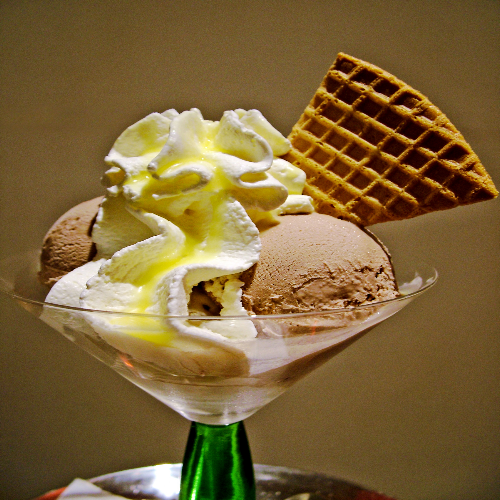

In [115]:
predict(icecream_url)

**Banana**

In [144]:
banana_url = "https://upload.wikimedia.org/wikipedia/commons/d/de/Bananavarieties.jpg"

[('beef_tartare', 33.023536682128906),
 ('beet_salad', 21.80827522277832),
 ('baby_back_ribs', 6.581998825073242),
 ('apple_pie', 2.01719069480896),
 ('beef_carpaccio', 1.929073452949524),
 ('breakfast_burrito', 1.8579710721969604),
 ('bread_pudding', 0.7745048403739929),
 ('beignets', 0.201981782913208),
 ('baklava', 0.08008503168821335),
 ('bibimbap', 0.0058058262802660465)]


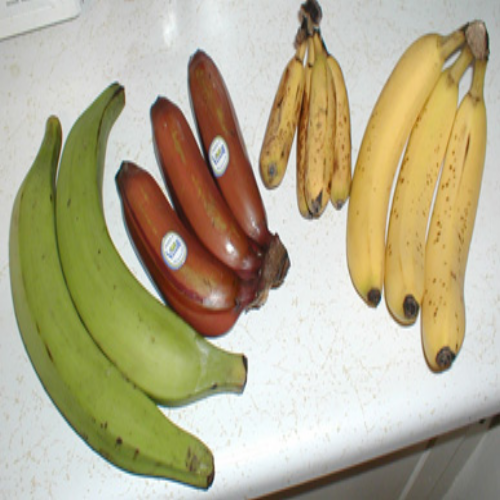

In [145]:
predict(banana_url)

# Prepare for production

In [58]:
path.ls()

[PosixPath('../data/subset/train'), PosixPath('../data/subset/models')]

In [121]:
shutil.rmtree("../models",ignore_errors=True)

In [122]:
shutil.copytree(path/"models", "../models")

'../models'

In [133]:
f"{learn.data.classes}"

"['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']"

In [141]:
with open('../models/classes.txt', 'w') as f:
    json.dump(learn.data.classes,f)

In [143]:
basicList

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']